<a href="https://colab.research.google.com/github/dannynacker/roX_gen/blob/main/session_11_sq_sin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sequence saved to strobe_sequence_periodic.txt
Sequence saved to strobe_sequence_aperiodic.txt


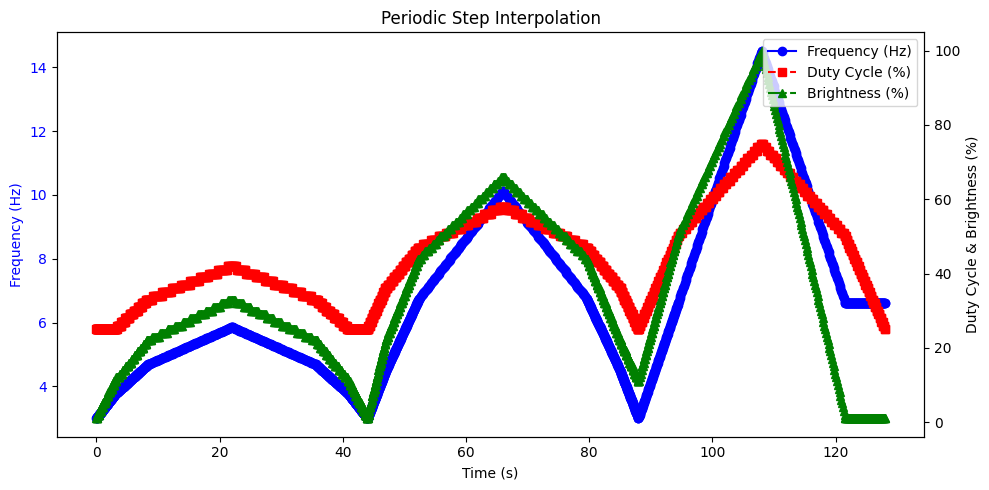

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt

def format_time(total_seconds):
    """Formats total_seconds as hh:mm:ss.s with leading zeros."""
    minutes = int(total_seconds // 60)
    seconds = int(total_seconds % 60)
    fraction = total_seconds - int(total_seconds)
    return f"00:{minutes:02}:{seconds:02}.{int(fraction * 10)}"

def format_stp(step_duration, wave_types, freqs, duties, led_assignments, intensities):
    """
    Formats a single STP line for up to 4 oscillators, ensuring no brackets appear.

    wave_types: list of 4 ints (e.g. [1,0,0,0] or [2,0,0,0])
    freqs, duties, intensities: each is a list of length 8:
        for oscillator i, [value_start, value_end]
    led_assignments: list of 4 sublists, each sublist for an oscillator (on/off).
    """
    blocks = []
    for osc in range(4):
        wt = wave_types[osc]
        f0, f1 = freqs[2*osc], freqs[2*osc+1]
        d0, d1 = duties[2*osc], duties[2*osc+1]
        i0, i1 = intensities[2*osc], intensities[2*osc+1]
        if wt != 0:
            # oscillator is active
            led_str = ",".join(map(str, led_assignments[osc]))
            block = f"{wt},{f0:.2f},{f1:.2f},{int(round(d0))},{int(round(d1))},{led_str},{int(round(i0))},{int(round(i1))}"
        else:
            # oscillator off
            block = f"0,{f0:.2f},{f0:.2f},{int(round(d0))},{int(round(d0))},0,0,0"
        blocks.append(block)
    return f'STP"{max(step_duration, 0.1):.1f},{",".join(blocks)}"'

def get_led_assignments():
    """All LEDs on for oscillator 0, off for oscillators 1-3."""
    return [[1, 1, 1, 1]] + [[0, 0, 0, 0] for _ in range(3)]

def generate_strobe_sequence(steps, condition):
    """
    Generates a strobe sequence (list of STP lines) for the given steps.
    Each step: (duration, f_start, f_end, duty_start, duty_end, bright_start, bright_end)

    - For 'periodic', one STP line per step (square wave).
    - For 'aperiodic', multiple lines per step (sine wave), each flash is 0.1s.
      Frequencies, duties, brightness are linearly interpolated for each flash,
      then random jitter is added to freq/duty (±7.92, ±25) with clamps [3..15], [25..75].
      Finally, iterative scaling is used to match total on-time.
    """
    output = []
    total_duration = sum(step[0] for step in steps)
    output.append(f'TIM"{format_time(total_duration).strip()}"')
    output.append(f'DUR"{total_duration:.1f}"')

    for step in steps:
        duration, f_start, f_end, d_start, d_end, b_start, b_end = step
        # Round everything to nearest integer as needed
        d_start = round(d_start)
        d_end   = round(d_end)
        b_start = round(b_start)
        b_end   = round(b_end)

        mean_freq = (f_start + f_end) / 2
        mean_duty = (d_start + d_end) / 2
        total_flashes = int(duration * mean_freq)
        expected_on_time = total_flashes * (1/mean_freq) * (mean_duty/100)
        led_config = get_led_assignments()

        if condition == "periodic":
            # One STP line per step, oscillator0 active (square wave=1).
            wave_types = [1, 0, 0, 0]
            freqs = [f_start, f_end, 0, 0, 0, 0, 0, 0]
            duties = [d_start, d_end, 0, 0, 0, 0, 0, 0]
            intensities = [b_start, b_end, 0, 0, 0, 0, 0, 0]
            stp_line = format_stp(duration, wave_types, freqs, duties, led_config, intensities)
            output.append(stp_line)
        else:
            # Aperiodic (sine wave=2). We'll build each flash individually.
            if total_flashes < 1:
                # If mean_freq is so low that total_flashes=0, skip
                continue

            # 1) For each flash index, linearly interpolate freq, duty, brightness
            base_params = []
            for idx in range(total_flashes):
                frac = idx / (total_flashes - 1) if total_flashes > 1 else 0
                freq_lin = f_start + frac*(f_end - f_start)
                duty_lin = d_start + frac*(d_end - d_start)
                bright_lin = b_start + frac*(b_end - b_start)
                freq_lin  = max(3, min(15, freq_lin))  # clamp freq just in case
                duty_lin  = round(max(25, min(75, duty_lin)))
                bright_lin= round(bright_lin)
                base_params.append((freq_lin, duty_lin, bright_lin))

            # 2) Add random jitter to freq/duty, ±7.92 for freq, ±25 for duty, then clamp
            new_candidate = []
            for (f_lin, d_lin, b_lin) in base_params:
                # freq
                freq_jittered = random.uniform(f_lin - 7.92, f_lin + 7.92)
                freq_jittered = max(3, min(15, freq_jittered))
                # duty
                duty_jittered = random.randint(d_lin - 25, d_lin + 25)
                duty_jittered = max(25, min(75, duty_jittered))
                # on-duration
                on_duration = (1/freq_jittered)*(duty_jittered/100)
                new_candidate.append([freq_jittered, duty_jittered, b_lin, on_duration])

            # 3) Iterative scaling to match expected on-time
            max_iterations = 1000
            tol = 0.01
            for iteration in range(max_iterations):
                actual_on_time = sum(x[3] for x in new_candidate)
                if abs(actual_on_time - expected_on_time) <= tol:
                    break
                scale_k = expected_on_time / actual_on_time if actual_on_time != 0 else 1
                # scale duty only
                for x in new_candidate:
                    x[1] = round(x[1]*scale_k)
                    x[1] = max(25, min(75, x[1]))
                    x[3] = (1/x[0])*(x[1]/100)

            # Now output one STP line per flash
            for freq_jittered, duty_jittered, bright_val, _ in new_candidate:
                wave_types = [2, 0, 0, 0]  # oscillator0 active, sine wave
                freqs = [freq_jittered, freq_jittered, 0, 0, 0, 0, 0, 0]
                duties = [duty_jittered, duty_jittered, 0, 0, 0, 0, 0, 0]
                intensities = [bright_val, bright_val, 0, 0, 0, 0, 0, 0]
                stp_line = format_stp(0.1, wave_types, freqs, duties, led_config, intensities)
                output.append(stp_line)

    return output, total_duration

def save_sequence_to_file(filename, lines):
    """Saves the list of STP lines to a text file."""
    with open(filename, "w", encoding="utf-8", newline="") as f:
        f.write("\r\n".join(lines))
    print(f"Sequence saved to {filename}")

def plot_periodic_steps(steps):
    """
    Plots frequency (Hz), duty cycle (%), and brightness (%) vs. time (s)
    using piecewise-linear interpolation across each step.

    Each step is a tuple:
        (duration, start_freq, end_freq, start_duty, end_duty, start_brightness, end_brightness)
    """
    time_vals = []
    freq_vals = []
    duty_vals = []
    bright_vals = []
    current_time = 0.0
    pts_per_step = 100

    for duration, f_start, f_end, d_start, d_end, b_start, b_end in steps:
        t_step = np.linspace(current_time, current_time + duration, pts_per_step)
        frac = np.linspace(0, 1, pts_per_step)
        freq_step = f_start + frac*(f_end - f_start)
        duty_step = np.round(d_start + frac*(d_end - d_start))
        bright_step = np.round(b_start + frac*(b_end - b_start))
        time_vals.append(t_step)
        freq_vals.append(freq_step)
        duty_vals.append(duty_step)
        bright_vals.append(bright_step)
        current_time += duration

    time_vals = np.concatenate(time_vals)
    freq_vals = np.concatenate(freq_vals)
    duty_vals = np.concatenate(duty_vals)
    bright_vals = np.concatenate(bright_vals)

    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(time_vals, freq_vals, 'b-', marker='o', label="Frequency (Hz)")
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Frequency (Hz)", color='b')
    ax1.tick_params(axis='y', labelcolor='b')

    ax2 = ax1.twinx()
    ax2.plot(time_vals, duty_vals, 'r--', marker='s', label="Duty Cycle (%)")
    ax2.plot(time_vals, bright_vals, 'g-.', marker='^', label="Brightness (%)")
    ax2.set_ylabel("Duty Cycle & Brightness (%)", color='k')
    ax2.tick_params(axis='y', labelcolor='k')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.title("Periodic Step Interpolation")
    plt.tight_layout()
    plt.show()


# ---------------------------
# Define Step Parameters
# ---------------------------
durations = [3, 5.4, 13.6, 13.6, 5.4, 3, 3, 5.4, 13.6, 13.6, 5.4, 3, 6.4, 13.6, 13.6, 6.4]
frequencies = [3, 3.75, 4.688, 5.859, 4.688, 3.75, 3, 4.5, 6.75, 10.125, 6.75, 4.5, 3, 6.6, 14.52, 6.6]
duty_cycle_ranges = [
    (25, 25), (25, 33), (33, 42), (42, 33),
    (33, 25), (25, 25), (25, 36), (36, 47),
    (47, 58), (58, 47), (47, 36), (36, 25),
    (25, 50), (50, 75), (75, 50), (50, 25)
]
brightness = [1, 11, 22, 33, 22, 11, 1, 22, 44, 66, 44, 22, 11, 50, 100, 1]

# Build steps.
steps = []
for i in range(len(durations)):
    dur = durations[i]
    f_start = frequencies[i]
    f_end   = frequencies[i+1] if i < len(durations)-1 else frequencies[i]
    d_start, d_end = duty_cycle_ranges[i]
    b_start = brightness[i]
    b_end   = brightness[i+1] if i < len(durations)-1 else brightness[i]
    steps.append((dur, f_start, f_end, d_start, d_end, b_start, b_end))

# Generate & save sequences
periodic_sequence, total_dur = generate_strobe_sequence(steps, condition="periodic")
save_sequence_to_file("strobe_sequence_periodic.txt", periodic_sequence)

aperiodic_sequence, total_dur = generate_strobe_sequence(steps, condition="aperiodic")
save_sequence_to_file("strobe_sequence_aperiodic.txt", aperiodic_sequence)

# Plot the periodic steps
plot_periodic_steps(steps)
